In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)

In [3]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [4]:
df.isna().sum()

Passengers    0
dtype: int64

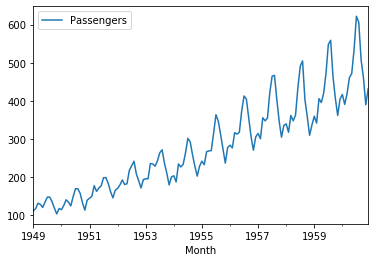

In [5]:
df.plot()

In [25]:
alpha = 0.2

In [26]:
df['EWMA'] = df['Passengers'].ewm(alpha=alpha, adjust=False).mean()

In [27]:
type(df['Passengers'].ewm(alpha=alpha, adjust=False))

pandas.core.window.ewm.EWM

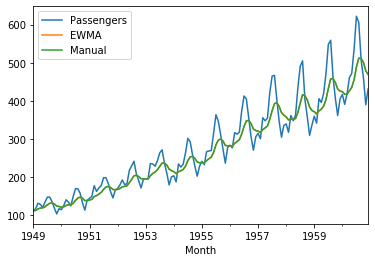

In [28]:
df.plot()

In [11]:
manual_ewma = []
for x in df['Passengers'].to_numpy():
    if len(manual_ewma) > 0:
        xhat = alpha * x + (1 - alpha) * manual_ewma[-1]
    else:
        xhat = x
    manual_ewma.append(xhat)
df['Manual'] = manual_ewma

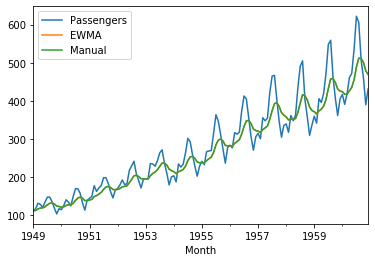

In [12]:
df.plot()

In [29]:
df.drop('Manual', axis=1, inplace=True)

In [35]:
!pip install -U statsmodels

     |████████████████████████████████| 9.5 MB 85 kB/s eta 0:00:011
     |████████████████████████████████| 40 kB 838 kB/s eta 0:00:01
     |████████████████████████████████| 233 kB 1.3 MB/s eta 0:00:01
  Attempting uninstall: packaging
    Found existing installation: packaging 20.4
    Uninstalling packaging-20.4:
      Successfully uninstalled packaging-20.4
  Attempting uninstall: patsy
    Found existing installation: patsy 0.5.1
    Uninstalling patsy-0.5.1:
      Successfully uninstalled patsy-0.5.1
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.1
    Uninstalling statsmodels-0.12.1:
      Successfully uninstalled statsmodels-0.12.1


In [36]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [37]:
ses = SimpleExpSmoothing(df['Passengers'])

/Users/maria/opt/miniconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


In [38]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq='MS')

In [39]:
df.index.freq = 'MS'

In [40]:
ses = SimpleExpSmoothing(df['Passengers'],
                         initialization_method='legacy-heuristic')

In [41]:
res = ses.fit(smoothing_level=alpha, optimized=False)

In [42]:
res

In [43]:
res.predict(start=df.index[0], end=df.index[-1])

Month
1949-01-01    112.000000
1949-02-01    112.000000
1949-03-01    113.200000
1949-04-01    116.960000
1949-05-01    119.368000
                 ...    
1960-08-01    488.767616
1960-09-01    512.214093
1960-10-01    511.371274
1960-11-01    501.297019
1960-12-01    479.037615
Freq: MS, Length: 144, dtype: float64

In [44]:
df['SES'] = res.predict(start=df.index[0], end=df.index[-1])

In [45]:
np.allclose(df['SES'], res.fittedvalues)

True

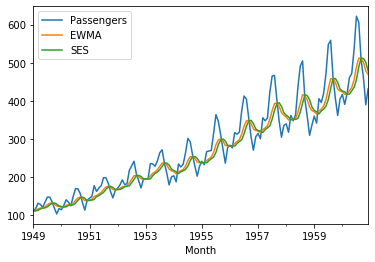

In [46]:
df.plot()

In [47]:
df.head()

,Passengers,EWMA,SES
Month,,,
1949-01-01,112,112.0000,112.000
1949-02-01,118,113.2000,112.000
1949-03-01,132,116.9600,113.200
1949-04-01,129,119.3680,116.960
1949-05-01,121,119.6944,119.368


In [48]:
df['SES-1'] = df['SES'].shift(-1)

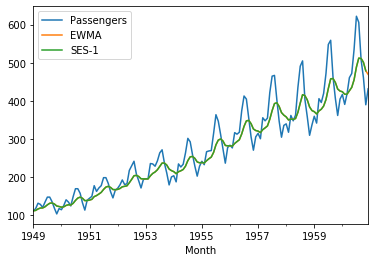

In [50]:
# WRONG!!!
df[['Passengers','EWMA','SES-1']].plot()

In [51]:
N_test = 12
train = df.iloc[:-N_test]
test = df.iloc[-N_test:]

In [53]:
ses = SimpleExpSmoothing(
    train['Passengers'],
    initialization_method='legacy-heuristic'
)
res = ses.fit()

In [60]:
# any row where the index is less than or equal to the last training point belongs to the train
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

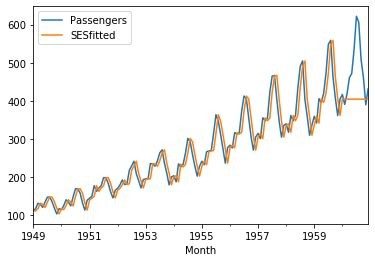

In [61]:
df.loc[train_idx, 'SESfitted'] = res.fittedvalues
df.loc[test_idx, 'SESfitted'] = res.forecast(N_test)
df[['Passengers','SESfitted']].plot();

In [64]:
df.tail()

,Passengers,EWMA,SES,SES-1,SESfitted
Month,,,,,
1960-08-01,606,512.214093,488.767616,512.214093,404.786132
1960-09-01,508,511.371274,512.214093,511.371274,404.786132
1960-10-01,461,501.297019,511.371274,501.297019,404.786132
1960-11-01,390,479.037615,501.297019,479.037615,404.786132
1960-12-01,432,469.630092,479.037615,NaN,404.786132


In [63]:
res.params

{'smoothing_level': 0.995,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 112.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [65]:
from statsmodels.tsa.holtwinters import Holt

In [66]:
holt = Holt(
    df['Passengers'],
    initialization_method='legacy-heuristic'
)

In [67]:
res_h = holt.fit()

In [68]:
df['Holt'] = res_h.fittedvalues

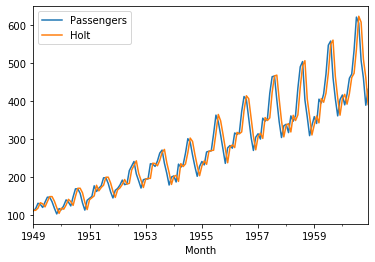

In [69]:
df[['Passengers','Holt']].plot();

In [71]:
holt = Holt(train['Passengers'], initialization_method='legacy-heuristic')
res_h = holt.fit()
df.loc[train_idx, 'Holt'] = res_h.fittedvalues

In [72]:
df.loc[test_idx, 'Holt'] = res_h.forecast(N_test)

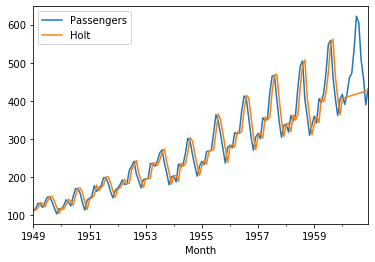

In [73]:
df[['Passengers','Holt']].plot();

In [74]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [78]:
hw = ExponentialSmoothing(
    train['Passengers'],
    initialization_method='legacy-heuristic',
    trend='add', seasonal='add', seasonal_periods=12
)
res_hw = hw.fit()

In [79]:
df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues

In [80]:
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)

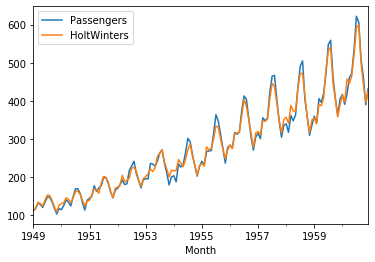

In [81]:
df[['Passengers','HoltWinters']].plot();

In [82]:
def rmse(y, t):
    return np.sqrt(np.mean((y -t)**2))

In [83]:
def mae(y, t):
    return np.mean(np.abs(y -t))

In [84]:
print('Train RMSE:', rmse(train['Passengers'], res_hw.fittedvalues))
print('Test RMSE:', rmse(test['Passengers'], res_hw.forecast(N_test)))

Train RMSE: 11.624714430673352
Test RMSE: 16.978029847029934


In [85]:
print('Train MAE:', mae(train['Passengers'], res_hw.fittedvalues))
print('Test MAE:', mae(test['Passengers'], res_hw.forecast(N_test)))

Train MAE: 9.006650631052384
Test MAE: 13.37759090303536


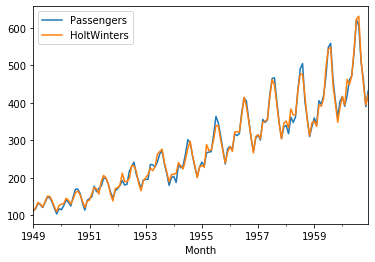

In [88]:
hw = ExponentialSmoothing(
    train['Passengers'],
    initialization_method='legacy-heuristic',
    trend='add', seasonal='mul', seasonal_periods=12
)
res_hw = hw.fit()
df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)
df[['Passengers','HoltWinters']].plot();

In [89]:
print('Train RMSE:', rmse(train['Passengers'], res_hw.fittedvalues))
print('Test RMSE:', rmse(test['Passengers'], res_hw.forecast(N_test)))

Train RMSE: 9.767995205168011
Test RMSE: 15.810870232569963


In [90]:
print('Train MAE:', mae(train['Passengers'], res_hw.fittedvalues))
print('Test MAE:', mae(test['Passengers'], res_hw.forecast(N_test)))

Train MAE: 7.604272329965027
Test MAE: 10.30368288348438


/Users/maria/opt/miniconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  def f(*args, **kwargs):


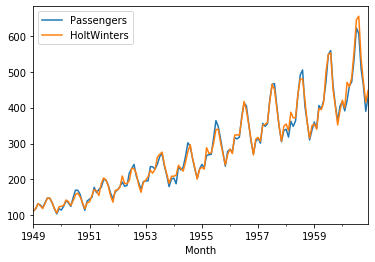

In [91]:
hw = ExponentialSmoothing(
    train['Passengers'],
    initialization_method='legacy-heuristic',
    trend='mul', seasonal='mul', seasonal_periods=12
)
res_hw = hw.fit()
df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)
df[['Passengers','HoltWinters']].plot();

In [92]:
print('Train RMSE:', rmse(train['Passengers'], res_hw.fittedvalues))
print('Test RMSE:', rmse(test['Passengers'], res_hw.forecast(N_test)))

Train RMSE: 9.61792487803932
Test RMSE: 25.80687515735493


In [93]:
print('Train MAE:', mae(train['Passengers'], res_hw.fittedvalues))
print('Test MAE:', mae(test['Passengers'], res_hw.forecast(N_test)))

Train MAE: 7.112379992634933
Test MAE: 20.844988412204554
